In [1]:
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from configs import limiting_schemes_2d, problem_configs, solver_config
from finite_volume.advection import AdvectionSolver


limiting_schemes = limiting_schemes_2d


viridis = mpl.colormaps["viridis"]


def color_p(p):
    return viridis(p / 7)

In [2]:
data = []
for n, p, lckey in product(
    [32, 64, 128, 256, 512], range(8), ["ZS2D-convergence", "ZS2D-T-convergence"]
):
    solver = AdvectionSolver(
        n=(n,),
        order=p + 1,
        cupy=256,
        snapshot_dt=1.0,
        num_snapshots=1,
        **problem_configs["sinus2d"],
        **limiting_schemes[lckey],
        load=False,
        save=False,
    )
    solver.rkorder(rk6=True)

    # measure error and record
    err = solver.snapshots[-1]["u"] - solver.snapshots[0]["u"]
    l1 = np.mean(np.abs(err))
    l2 = np.sqrt(np.mean(np.square(err)))
    integrator_names = {
        "euler": "Euler",
        "ssprk2": "SSPRK2",
        "ssprk3": "SSPRK3",
        "rk4": "RK4",
        "rk6": "RK6",
    }
    data.append(
        dict(
            n=n,
            p=p,
            integrator=integrator_names[solver.integrator_name],
            C=solver.courant,
            scheme=lckey,
            l1_err=l1,
            l2_err=l2,
        )
    )

df = pd.DataFrame(data)

Try a  CFL factor less than 0.16667

Try a  CFL factor less than 0.16667

Try a  CFL factor less than 0.08333

Try a  CFL factor less than 0.08333

Reassigned C=0.44898481932374923 for order 7
Try a  CFL factor less than 0.05000

Reassigned C=0.44898481932374923 for order 7
Reassigned C=0.25198420997897464 for order 8
Try a  CFL factor less than 0.05000

Reassigned C=0.25198420997897464 for order 8
Try a  CFL factor less than 0.16667

Try a  CFL factor less than 0.16667

Try a  CFL factor less than 0.08333

Try a  CFL factor less than 0.08333

Reassigned C=0.4 for order 7
Try a  CFL factor less than 0.05000

Reassigned C=0.4 for order 7
Reassigned C=0.2 for order 8
Try a  CFL factor less than 0.05000

Reassigned C=0.2 for order 8
Try a  CFL factor less than 0.16667

Try a  CFL factor less than 0.16667

Try a  CFL factor less than 0.08333

Try a  CFL factor less than 0.08333

Reassigned C=0.35635948725613575 for order 7
Try a  CFL factor less than 0.05000

Reassigned C=0.356359487256135

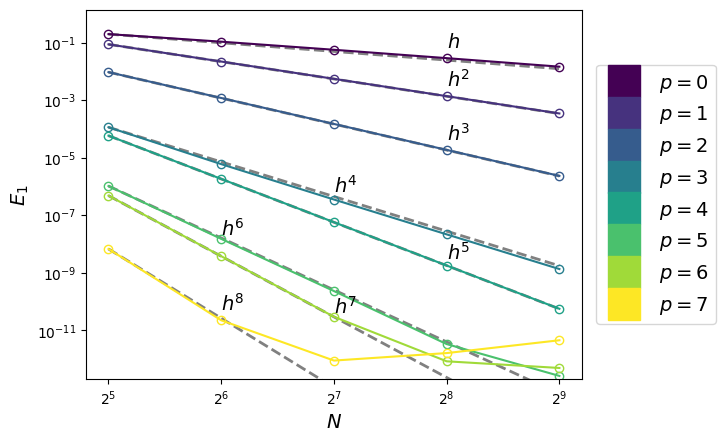

In [3]:
# plotting
fig, ax = plt.subplots()
ax.set_xscale("log", base=2)
ax.set_yscale("log")

plotted_scheme = "ZS2D-convergence"

df_plot = df[df.scheme == plotted_scheme]

p_grouped = df_plot.groupby("p")

# plot theoretical curves
for p_name, p_group in p_grouped:
    y0 = p_group.l1_err.max()
    n0 = p_group.n.min()
    nmax = p_group.n.max()
    n_ratio = n0 / nmax
    ypred = y0 * (n_ratio ** (p_name + 1))
    ax.plot([n0, nmax], [y0, ypred], linestyle="--", linewidth=2, color="grey")

# plot actual curves
for p_name, p_group in p_grouped:
    ax.plot(
        p_group.n,
        p_group.l1_err,
        "-",
        marker="o",
        color=color_p(p_name),
        mfc="none",
        label=f"$p={p_name}$",
    )

# labels
fontsize = 14
ax.text(2**8, 7e-2, "$h$", size=fontsize)
ax.text(2**8, 3e-3, "$h^2$", size=fontsize)
ax.text(2**8, 4e-5, "$h^3$", size=fontsize)
ax.text(2**7, 6e-7, "$h^4$", size=fontsize)
ax.text(2**8, 3e-9, "$h^5$", size=fontsize)
ax.text(2**6, 2e-8, "$h^6$", size=fontsize)
ax.text(2**7, 4e-11, "$h^7$", size=fontsize)
ax.text(2**6, 5e-11, "$h^8$", size=fontsize)

# cosmetics
leg = ax.legend(loc="center", bbox_to_anchor=(1.15, 0.5), fontsize=fontsize)
for line, p in zip(leg.get_lines(), range(8)):
    line.set_linestyle("none")
    line.set_marker("s")
    line.set_markersize(23)
    line.set_markerfacecolor(color_p(p))
ax.set_ylim(2e-13, None)
ax.set_xlabel("$N$", fontsize=fontsize)
ax.set_ylabel("$E_1$", fontsize=fontsize)
fig.savefig(
    f"images/sinus_convergence_{plotted_scheme}.png", dpi=300, bbox_inches="tight"
)

In [4]:
# add columns for computing actual error rate
df = df.sort_values(by=["scheme", "p", "n"])

l1_err = df.l1_err.to_numpy()
rates = np.full_like(df.l1_err, np.nan)
rates[1:] = np.log2(l1_err[:-1] / l1_err[1:])
df["l1_err_rate"] = rates

l2_err = df.l2_err.to_numpy()
rates = np.full_like(df.l1_err, np.nan)
rates[1:] = np.log2(l2_err[:-1] / l2_err[1:])
df["l2_err_rate"] = rates

df.loc[df.n == 32, ("l1_err_rate", "l2_err_rate")] = None

df[10:30]

,n,p,integrator,C,scheme,l1_err,l2_err,l1_err_rate,l2_err_rate
5,32,2,SSPRK3,0.8,ZS2D-T-convergence,9.381216e-03,1.042056e-02,NaN,NaN
21,64,2,SSPRK3,0.8,ZS2D-T-convergence,1.185574e-03,1.316865e-03,2.984189,2.984254
37,128,2,SSPRK3,0.8,ZS2D-T-convergence,1.484856e-04,1.649268e-04,2.997191,2.997210
53,256,2,SSPRK3,0.8,ZS2D-T-convergence,1.856786e-05,2.062373e-05,2.999443,2.999448
69,512,2,SSPRK3,0.8,ZS2D-T-convergence,2.321177e-06,2.578180e-06,2.999879,2.999880
7,32,3,RK4,0.8,ZS2D-T-convergence,9.480077e-05,1.054104e-04,NaN,NaN
23,64,3,RK4,0.8,ZS2D-T-convergence,4.279434e-06,4.751472e-06,4.469407,4.471499
39,128,3,RK4,0.8,ZS2D-T-convergence,2.340305e-07,2.599910e-07,4.192652,4.191841
55,256,3,RK4,0.8,ZS2D-T-convergence,1.405935e-08,1.561607e-08,4.057094,4.057359
71,512,3,RK4,0.8,ZS2D-T-convergence,8.697889e-10,9.660912e-10,4.014721,4.014728


In [5]:
# reformat dataframe for table generation
df_l1 = df
df_l1 = df_l1.drop(columns=["l2_err", "l2_err_rate"])
df_l1 = df_l1.rename(columns={"l1_err": "err", "l1_err_rate": "err_rate"})
df_l1["err_type"] = "L1"
df_l2 = df
df_l2 = df_l2.drop(columns=["l1_err", "l1_err_rate"])
df_l2 = df_l2.rename(columns={"l2_err": "err", "l2_err_rate": "err_rate"})
df_l2["err_type"] = "L2"
df = pd.concat([df_l1, df_l2])

df_abs = df
df_abs = df_abs.drop(columns="err_rate")
df_abs["val_type"] = "abs"
df_rate = df
df_rate = df_rate.drop(columns="err")
df_rate = df_rate.rename(columns={"err_rate": "err"})
df_rate["val_type"] = "rate"
df = pd.concat([df_abs, df_rate])

# reformat float
df["C"] = df["C"].apply("{:.2f}".format)
df["err"] = df.apply(
    lambda row: f"{row['err']:.2E}"
    if row["val_type"] == "abs"
    else f"{row['err']:.3f}",
    axis=1,
)
df["err"] = df.apply(
    lambda row: "\u2014" if row["err"] == "nan" else row["err"], axis=1
)

# rename columns
df = df.rename(columns={"n": "$N$", "p": "$p$", "C": "$C$"})

In [6]:
table = pd.pivot_table(
    df,
    values=[
        "err",
    ],
    index=["$p$", "integrator", "$N$", "$C$"],
    columns=["err_type", "scheme", "val_type"],
    aggfunc=lambda x: x,
)
print(table.to_latex())

\begin{tabular}{llllllllllll}
\toprule
 &  &  &  & \multicolumn{8}{r}{err} \\
 &  &  & err_type & \multicolumn{4}{r}{L1} & \multicolumn{4}{r}{L2} \\
 &  &  & scheme & \multicolumn{2}{r}{ZS2D-T-convergence} & \multicolumn{2}{r}{ZS2D-convergence} & \multicolumn{2}{r}{ZS2D-T-convergence} & \multicolumn{2}{r}{ZS2D-convergence} \\
 &  &  & val_type & abs & rate & abs & rate & abs & rate & abs & rate \\
$p$ & integrator & $N$ & $C$ &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{5}{*}{0} & \multirow[t]{5}{*}{Euler} & 32 & 0.80 & 1.97E-01 & — & 1.97E-01 & — & 2.19E-01 & — & 2.19E-01 & — \\
\cline{3-12}
 &  & 64 & 0.80 & 1.08E-01 & 0.873 & 1.08E-01 & 0.873 & 1.19E-01 & 0.873 & 1.19E-01 & 0.873 \\
\cline{3-12}
 &  & 128 & 0.80 & 5.63E-02 & 0.935 & 5.63E-02 & 0.935 & 6.25E-02 & 0.935 & 6.25E-02 & 0.935 \\
\cline{3-12}
 &  & 256 & 0.80 & 2.88E-02 & 0.967 & 2.88E-02 & 0.967 & 3.20E-02 & 0.967 & 3.20E-02 & 0.967 \\
\cline{3-12}
 &  & 512 & 0.80 & 1.46E-02 & 0.983 & 1.46E-02 & 0.983 & 1.62E-02 & 0.